[![launch on mybinger.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDMachine.jl.git/master?filepath=vis/plot_CliMa.ipynb)   
[![open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDMachine.jl/blob/master/vis/plot_CliMa.ipynb)

In [11]:
"""
clone and install PySDM dependencies in Colab
(to use GPU on Colab set hardware accelerator to 'GPU' before session start
in the "Runtime :: Change runtime type :: Hardware accelerator" menu)
"""
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PySDMachine.jl'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PySDMachine.jl.git
    %cd PySDMachine.jl
    !pip install -r requirements.txt
    %cd vis

In [2]:
import os                                                                       
import numpy as np                                                              
import matplotlib.pyplot as plt                                                 
import matplotlib.colors as colors                                              
import matplotlib as mpl                                                        
from netCDF4 import Dataset                                                     
from copy import copy   

In [4]:
# TODO - should be read in from CLIMAParameters.jl                              
rho_l = 1e3                                                                     
Mv = 18e-3                                                                      
Md = 28.97e-3                                                                   
Rd = 8.3144598  / Md                                                            
eps = Mv/Md       

In [5]:
def dry_density(rho, p, T, q_tot, q_vap, q_liq):                                
    """                                                                         
    Computes dry air density based on air density and water specific humidites. 
    """                                                                         
    q_dry = 1. - q_tot                                                          
    q_vap[q_vap < 0.0] = 0.0                                                    
    q_liq[q_liq < 0.0] = 0.0                                                    
                                                                                
    # TODO - what should we do with the liquid water?                           
    rho_d = (rho - p / Rd / T / (1/q_vap + 1/eps - 1.)) / q_dry                 
                                                                                
    return rho_d 

In [6]:
# read the data                                                                 
# assumes there is only one aux and one state output file                       
clima_output = "../output/"                                   
for fname in os.listdir(clima_output):                                          
    if fname.startswith("KinematicModel_DumpAux"):                              
        aux_f = clima_output + fname                                            
    if fname.startswith("KinematicModel_DumpState"):                            
        state_f = clima_output + fname                                          
                                                                                
aux_data = Dataset(aux_f, 'r')                                                  
state_data = Dataset(state_f, 'r')                                              
                                                                                
y_idx = 5                                                                       
z = state_data["z"][:]                                                          
x = state_data["x"][:]                                                          
time = aux_data["time"][:]                                                      
rho = np.array(state_data["ρ"][:])[:, :,  y_idx, :]                             
                                                                                
vars = ["p", "u", "w", \
        "q_tot", "q_vap", "q_liq", "q_ice",\
        "e_tot", "e_kin", "e_pot", "e_int", "T", "S", "RH"]                     
data_dict = {}                                                                  
for var in vars:                                                                
    data_dict[var] = np.array(aux_data.variables[var][:])[:, :,  y_idx, :] 

In [7]:
t_idx = 0 #[0, 1, ..., 6]

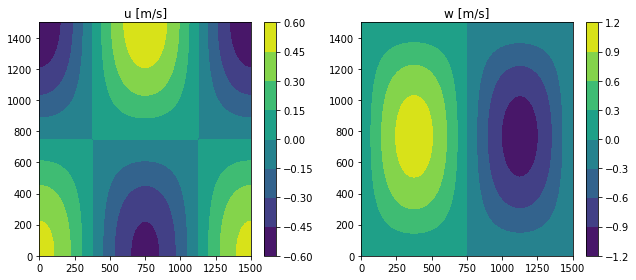

In [8]:
# plot velocity field                                                           
fig, axs = plt.subplots(1,2, figsize=(9, 4))                                    
im1 = axs[0].contourf(x, z, data_dict["u"][t_idx, :, :])                        
im2 = axs[1].contourf(x, z, data_dict["w"][t_idx, :, :])                        
axs[0].set_title("u [m/s]")                                                     
axs[1].set_title("w [m/s]")                                                     
fig.colorbar(im1, ax=axs[0])                                                    
fig.colorbar(im2, ax=axs[1])                                                    
plt.tight_layout()                                                              
plt.show()

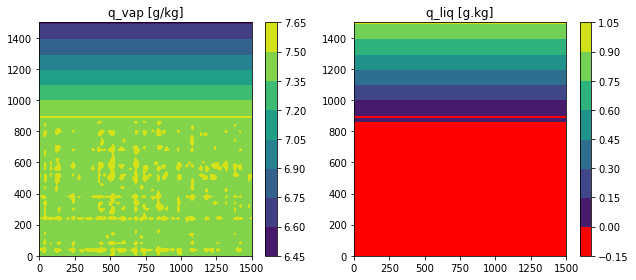

In [9]:
# plot water                                                                    
cmap2 = copy(mpl.cm.get_cmap("viridis"))                                        
fig, axs = plt.subplots(1,2, figsize=(9, 4))                                    
im1 = axs[0].contourf(x, z, data_dict["q_vap"][t_idx, :, :] * 1e3)              
im2 = axs[1].contourf(x, z, data_dict["q_liq"][t_idx, :, :] * 1e3, vmin=0.0, cmap=cmap2)
im2.cmap.set_under('red')                                                       
axs[0].set_title("q_vap [g/kg]")                                                
axs[1].set_title("q_liq [g.kg]")                                                
fig.colorbar(im1, ax=axs[0])                                                    
fig.colorbar(im2, ax=axs[1])                                                    
plt.tight_layout()                                                              
plt.show() 

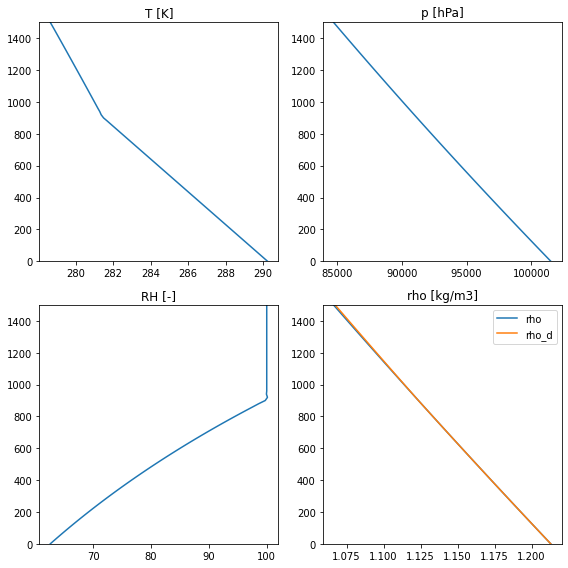

In [10]:
#plot initial profiles of T, p, RH, rho (TODO - should be dry density)          
rho_d = dry_density(rho[: , :, :],\
                    data_dict["p"],\
                    data_dict["T"],\
                    data_dict["q_tot"],\
                    data_dict["q_vap"],\
                    data_dict["q_liq"])                                         
fig, axs = plt.subplots(2,2, figsize=(8, 8))                                    
im1 = axs[0, 0].plot(np.average(data_dict["T"][t_idx, :, :], axis=1), z)        
im2 = axs[0, 1].plot(np.average(data_dict["p"][t_idx, :, :], axis=1), z)        
im3 = axs[1, 0].plot(np.average(data_dict["RH"][t_idx, :, :], axis=1), z)       
im4 = axs[1, 1].plot(np.average(rho[t_idx, :, :], axis=1), z, label="rho")      
im4 = axs[1, 1].plot(np.average(rho_d[t_idx, :, :], axis=1), z, label="rho_d")  
axs[1, 1].legend()                                                              
axs[0, 0].set_title("T [K]")                                                    
axs[0, 1].set_title("p [hPa]")                                                  
axs[1, 0].set_title("RH [-]")                                                   
axs[1, 1].set_title("rho [kg/m3]")                                              
for xx in range(2):                                                             
    for yy in range(2):                                                         
        axs[xx,yy].set_ylim((0, 1500))                                          
plt.tight_layout()                                                              
plt.show()